In [1]:
import warnings

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# %%
import SpaCross as TOOLS

In [3]:
def load_hypothalamus(slice_names):
    Batch_list = []
    for idxxx, slice_id in enumerate(slice_names):
        adata = sc.read(r"D:\project\datasets\merfish\MERFISH\hypothalamus"+slice_id+'.h5ad')
        adata.var_names_make_unique(join="++")
        adata.obs['slice_id'] = idxxx
        print(slice_id, adata.X.shape)
        # make spot name unique
        adata.obs_names = [x + slice_id for x in adata.obs_names]
        adata.var_names_make_unique()
        adata.layers['count'] = adata.X.toarray()
        sc.pp.normalize_total(adata, target_sum=1e6)
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=155)
        adata = adata[:, adata.var['highly_variable'] == True]
        sc.pp.scale(adata)
        adata = adata[:, adata.var['highly_variable']]
        Batch_list.append(adata)
        
    return Batch_list

In [4]:
import anndata as ad

def vertical_list_alignment(list_adata, batch_categories, batch_key="slice_name", align=True, rad_cutoff=150,
                            plot=False, coor_key='spatial'):
    if plot:
        from matplotlib import cm
        import matplotlib
        import matplotlib.pyplot as plt
        # Choose colors
        cmap = cm.get_cmap('rainbow', len(list_adata))
        colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(list_adata))]

        # Plot spots before alignment
        plt.figure(figsize=(5, 5))
        plt.title("Before alignment")
        for i in range(len(list_adata)):
            plt.scatter(list_adata[i].obsm[coor_key][:, 0],
                        list_adata[i].obsm[coor_key][:, 1],
                        c=colors_list[i],
                        label="Slice %d spots" % i, s=5., alpha=0.5)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
        plt.show()
    # assert len(list_adata)==len(list_z)
    
    assert len(list_adata) >= 2
    isfrist = True
    for idx, tadata, b in zip(range(len(list_adata)), list_adata, batch_categories):
        tadata.obs[batch_key] = b
        if isfrist:
            a_x = tadata.obs["array_row"].mean()
            a_y = tadata.obs["array_col"].mean()
            print(a_x, a_y)
            isfrist = False
            tadata.obsm["spatial_aligned"] = tadata.obsm[coor_key].copy()
            tadata.obsm["spatial_aligned"] = np.column_stack((tadata.obs['array_row'], tadata.obs['array_col']))
            list_adata[idx] = tadata
            continue
        if align:
            tx = tadata.obs["array_row"].mean()
            ty = tadata.obs["array_col"].mean()

            tadata.obs["array_row"] = tadata.obs["array_row"] + a_x - tx
            tadata.obs["array_col"] = tadata.obs["array_col"] + a_y - ty
        
            tadata.obsm["spatial_aligned"] = tadata.obsm[coor_key].copy()
            tadata.obsm["spatial_aligned"] = np.column_stack((tadata.obs['array_row'], tadata.obs['array_col']))
            list_adata[idx] = tadata
        
    if plot:
        plt.figure(figsize=(5, 5))
        plt.title("After alignment")
        for i in range(len(list_adata)):
            plt.scatter(list_adata[i].obsm["spatial_aligned"][:, 0],
                        list_adata[i].obsm["spatial_aligned"][:, 1],
                        c=colors_list[i],
                        label="Slice %d spots" % i, s=5., alpha=0.5)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc=(1.02, .2), ncol=(len(list_adata) // 13 + 1))
        plt.show()
    
    return list_adata

In [5]:
slice_names = ['-0.04', '-0.09', '-0.14', '-0.19', '-0.24' ]
Batch_list = load_hypothalamus(slice_names)

-0.04 (5488, 155)
-0.09 (5557, 155)
-0.14 (5926, 155)
-0.19 (5803, 155)
-0.24 (5543, 155)


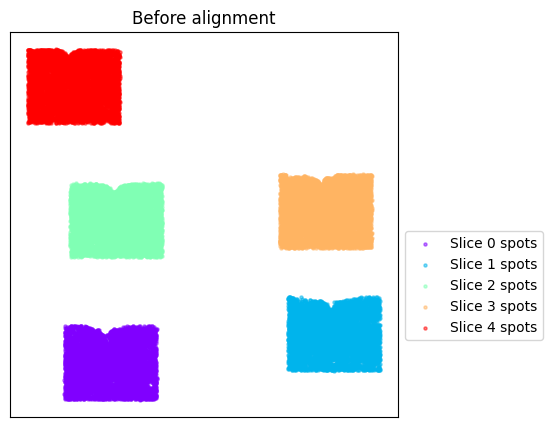

-2148.001710696611 3729.2713008903065


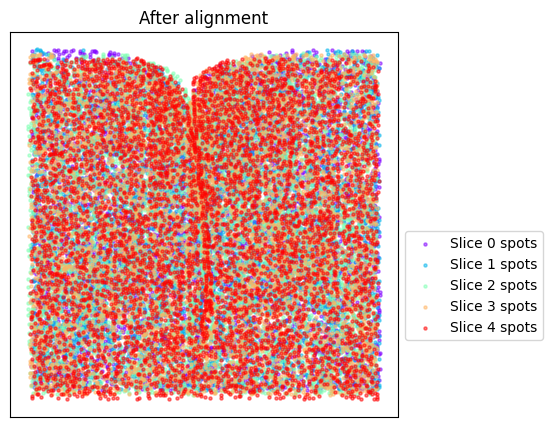

In [6]:
list_adata = vertical_list_alignment(Batch_list, slice_names, plot=True)

In [7]:
with open('../Config/MERFISH.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [8]:
adata, edge_index = TOOLS.graph_construction3D(Batch_list, section_ids=slice_names, k_cutoff=config['data']['k_cutoff'], rad_coef=1.1, mode='KNN', slice_dist_micron=[10000/3.559 * 1.1, 10000/3.559 * 1.1, 10000/3.559 * 1.1, 10000/3.559 * 1.1])
# adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata.X

Start building a graph...
Radius for graph connection is 3.5590.
The graph contains 226536 edges, 28317 cells.
8.0000 neighbors per cell on average.


In [9]:
num_clusters = 8

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = TOOLS.SC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)
# %%
net.trian()
# %%
enc_rep, recon = net.process()

Epoch 299 total loss=1.133 recon loss=1.078 mean loss=0.449 tri loss=1.381: 100%|██████████| 300/300 [03:06<00:00,  1.61it/s]


In [10]:
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon

In [11]:
# %%
clusType = 'mclust'
adata.obs[clusType] = TOOLS.clustering(z=enc_rep, n_clust=num_clusters, num_seed=1, method=clusType)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


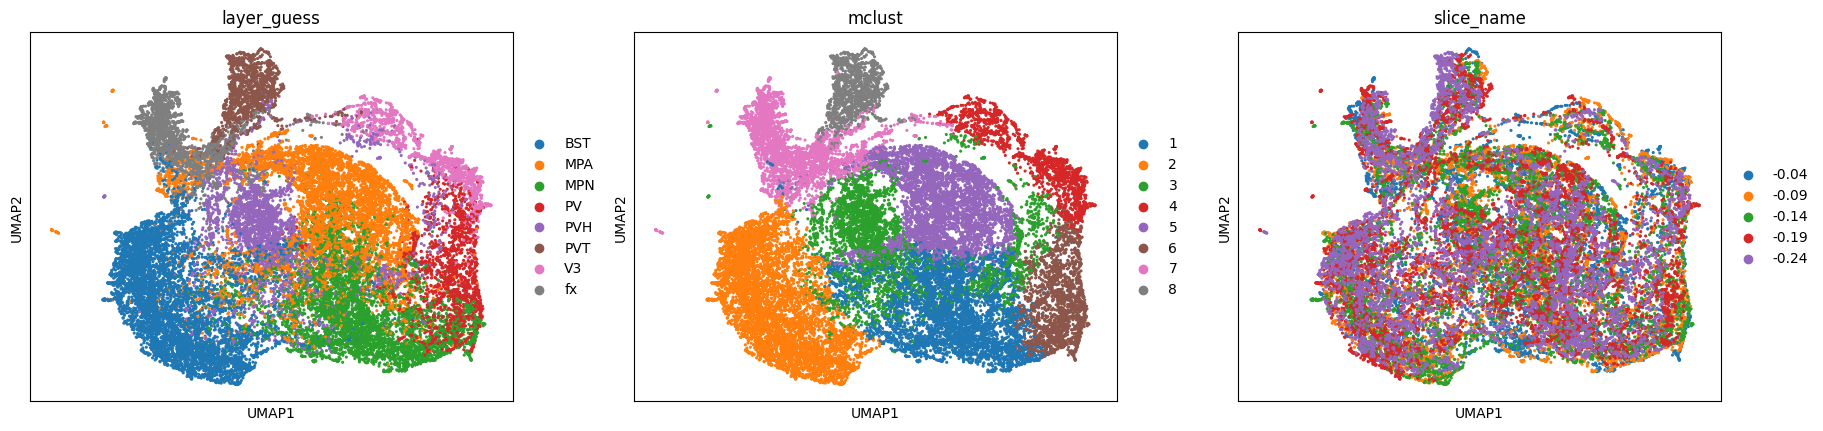

In [12]:
spot_size = 20
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'slice_name'], show=True, size=spot_size, save=False)

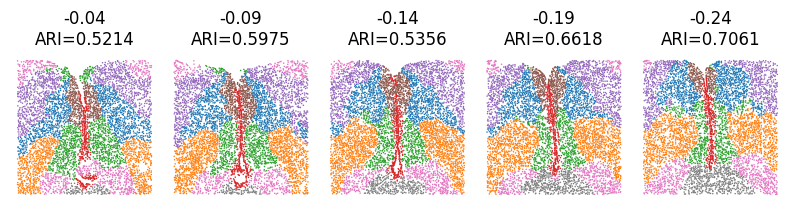

In [13]:

title_size = 12
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(slice_names), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(slice_names):
    sub_adata = adata[adata.obs['slice_name'] == name]
    sub_adata.obs["mclust"] = TOOLS.refine_label(sub_adata, 30, key="mclust")
    sub_adata_tmp = sub_adata[~pd.isnull(sub_adata.obs['layer_guess'])]
    ARI, ACC, DIS = TOOLS.get_metrics(sub_adata_tmp, 'layer_guess', "mclust")
    _sc_ = sc.pl.spatial(sub_adata, img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title(name + "\nARI=" + str(round(ARI, 4)), size=title_size)
plt.show()